In [1]:
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from __future__ import division
from IPython.core.debugger import set_trace

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
shoppings = pd.read_csv('./data/supermarket_data.csv')
shoppings['SHOP_DATE'] = shoppings['SHOP_DATE'].apply(str)
shoppings['SHOP_DATE'] = pd.to_datetime(shoppings['SHOP_DATE'], format='%Y%m%d')

In [3]:
shoppings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671914 entries, 0 to 671913
Data columns (total 8 columns):
SHOP_DATE     671914 non-null datetime64[ns]
SHOP_HOUR     671914 non-null int64
BASKET_ID     671914 non-null int64
CUST_CODE     671914 non-null object
STORE_CODE    671914 non-null object
PROD_CODE     671914 non-null object
QUANTITY      671914 non-null int64
SPEND         671914 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 41.0+ MB


In [4]:
NOW = shoppings['SHOP_DATE'].max()

In [5]:
m_table = shoppings.groupby(['CUST_CODE','BASKET_ID'], as_index=False)['SPEND'].mean().drop(columns=['BASKET_ID']).groupby('CUST_CODE', as_index=False)['SPEND'].sum()
m_table = m_table.rename(columns={
    'SPEND' : 'monetary'
})

rf_table = shoppings.groupby(['CUST_CODE'], as_index=False).agg({
    'BASKET_ID': lambda x: len(x.unique()),
    'SHOP_DATE': lambda x: (NOW - x.max()).days
}).rename(columns={
    'BASKET_ID' : 'frequency',
    'SHOP_DATE' : 'recency'
})

In [6]:
rmf_table = pd.merge(left=m_table, right=rf_table, on='CUST_CODE')

In [7]:
m_3nd_quantile = rmf_table['monetary'].quantile(.75)
r_3nd_quantile = rmf_table['recency'].quantile(.75)
f_3nd_quantile = rmf_table['frequency'].quantile(.75)

rmf_table['m_score'] = rmf_table['monetary'].apply(lambda x: 1 if x > m_3nd_quantile else 2)
rmf_table['r_score'] = rmf_table['recency'].apply(lambda x: 1 if x < r_3nd_quantile else 2)
rmf_table['f_score'] = rmf_table['frequency'].apply(lambda x: 1 if x > f_3nd_quantile else 2)


In [8]:
rmf_table['rmf'] = rmf_table['r_score'].apply(str) + rmf_table['m_score'].apply(str) + rmf_table['f_score'].apply(str)

In [9]:
rmf_count = rmf_table.groupby('rmf', as_index=False)['CUST_CODE'].count()

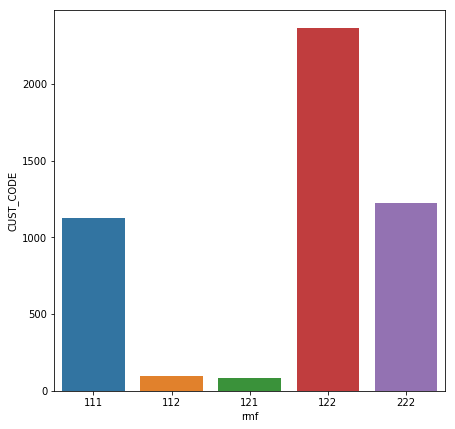

In [10]:
plt.figure(figsize=(7, 7))
sns.barplot(data=rmf_count, x='rmf', y='CUST_CODE')
plt.show()

In [11]:
total_spend_by_customers = shoppings.groupby('CUST_CODE', as_index=False)['SPEND'].sum()

In [12]:
customers = pd.merge(total_spend_by_customers, rmf_table, on='CUST_CODE')

In [13]:
total_spend_by_rmf = customers.groupby('rmf', as_index=False)['SPEND'].sum()

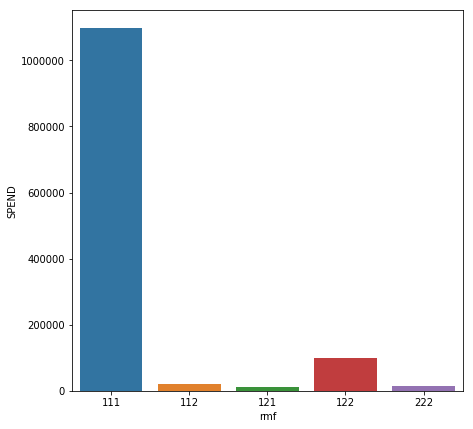

In [14]:
plt.figure(figsize=(7, 7))
sns.barplot(data=total_spend_by_rmf, x='rmf', y='SPEND')
plt.show()

## First Tier Customers Analysis

In [15]:
first_tier_customer_code = rmf_table.loc[rmf_table['rmf'] == '111', 'CUST_CODE'].values

data = pd.merge(shoppings, rmf_table[['CUST_CODE', 'rmf']], on='CUST_CODE')
first_tier_customers = data.loc[data['rmf'] == '111']

### Which day they come?

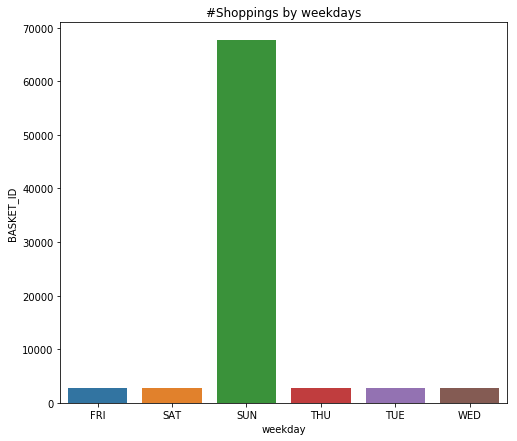

In [16]:
def map_to_weekday(x):
    if x == 0:
        return 'MON'
    elif x == 1:
        return 'TUE'
    elif x == 2:
        return 'WED'
    elif x == 3:
        return 'THU'
    elif x == 4:
        return 'FRI'
    elif x == 5:
        return 'SAT'
    else:
        return 'SUN'

first_tier_customers['weekday'] = first_tier_customers['SHOP_DATE'].apply(lambda x: map_to_weekday(x.day))

total_basket_by_weekday = first_tier_customers.groupby('weekday', as_index=False)['BASKET_ID'].agg(lambda x: len(x.unique()))

plt.figure(figsize=(8,7))
sns.barplot(data=total_basket_by_weekday, x='weekday', y='BASKET_ID')
plt.title("#Shoppings by weekdays")
plt.show()

### Which time they come?

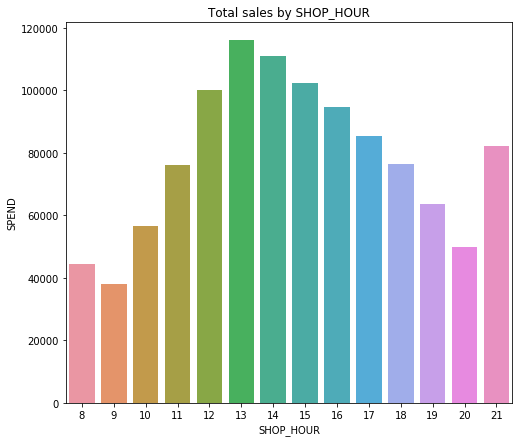

In [17]:
total_spend_by_shop_hour = first_tier_customers.groupby('SHOP_HOUR', as_index=False)['SPEND'].sum()

plt.figure(figsize=(8,7))
sns.barplot(data=total_spend_by_shop_hour, x='SHOP_HOUR', y='SPEND')
plt.title("Total sales by SHOP_HOUR")
plt.show()


### Which quater has the most sales?

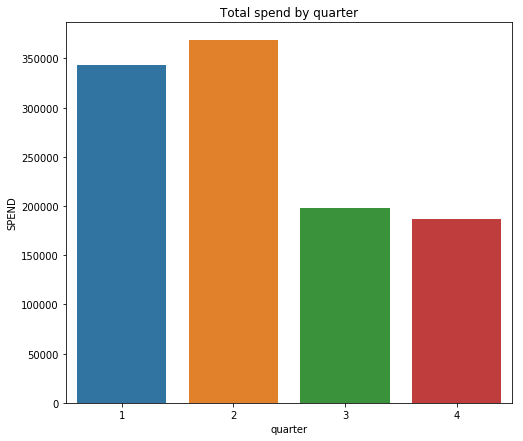

In [18]:
first_tier_customers['quarter'] = first_tier_customers['SHOP_DATE'].apply(lambda x: x.quarter)
total_spend_by_quarter = first_tier_customers.groupby('quarter', as_index=False)['SPEND'].sum()

plt.figure(figsize=(8,7))
sns.barplot(data=total_spend_by_quarter, x='quarter', y='SPEND')
plt.title("Total spend by quarter")
plt.show()

### Which store has the most sales?

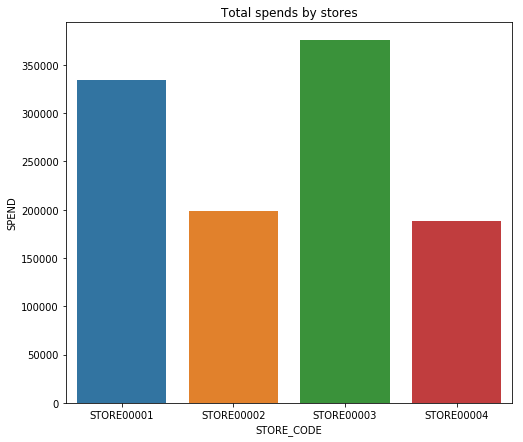

In [19]:
#total_basket_by_store = first_tier_customers.groupby('STORE_CODE', as_index=False)['BASKET_ID'].agg(lambda x: len(x.unique()))
total_spend_by_store = first_tier_customers.groupby('STORE_CODE', as_index=False)['SPEND'].sum()

plt.figure(figsize=(8,7))
sns.barplot(data=total_spend_by_store, x='STORE_CODE', y='SPEND')
plt.title("Total spends by stores")
plt.show()


### Which store has most of them?

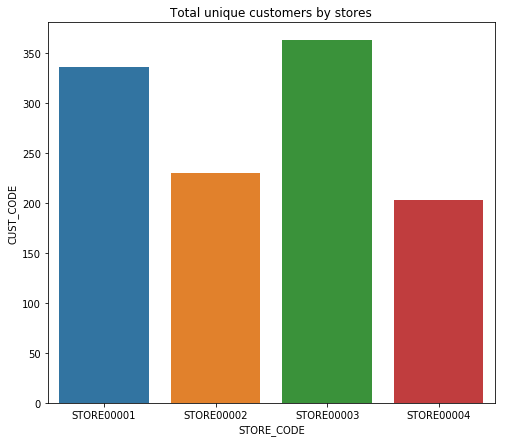

In [20]:
total_customers_by_store = first_tier_customers.groupby('STORE_CODE', as_index=False)['CUST_CODE'].agg(lambda x: len(x.unique()))

plt.figure(figsize=(8,7))
sns.barplot(data=total_customers_by_store, x='STORE_CODE', y='CUST_CODE')
plt.title("Total unique customers by stores")
plt.show()

### Which products they bought yeild most salse?

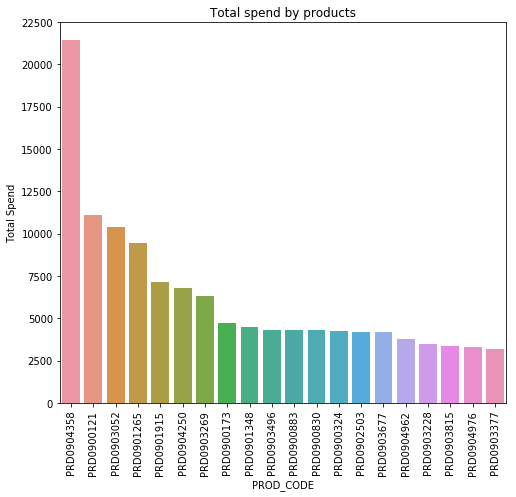

In [21]:
totle_spend_by_products = first_tier_customers.groupby('PROD_CODE', as_index=False)['SPEND'].sum()
top_products = totle_spend_by_products.sort_values('SPEND', ascending=False)[:20]

plt.figure(figsize=(8,7))
sns.barplot(data=top_products, x='PROD_CODE', y='SPEND')
plt.title("Total spend by products")
plt.xticks(rotation=90)
plt.ylabel('Total Spend')
plt.show()

### Which product thay buy most?

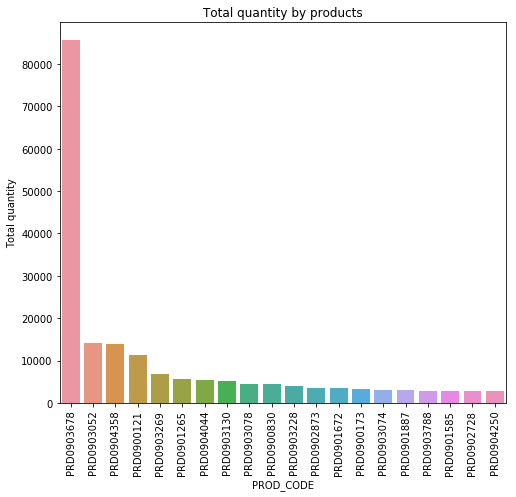

In [22]:
totle_shopped_by_products = first_tier_customers.groupby('PROD_CODE', as_index=False)['QUANTITY'].sum()
top_products = totle_shopped_by_products.sort_values('QUANTITY', ascending=False)[:20]

plt.figure(figsize=(8,7))
sns.barplot(data=top_products, x='PROD_CODE', y='QUANTITY')
plt.title("Total quantity by products")
plt.xticks(rotation=90)
plt.ylabel('Total quantity')
plt.show()

### How often they shopping?

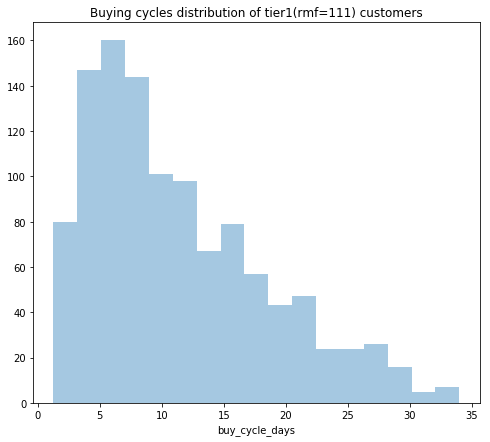

In [23]:
shoppings['SHOP_DATE_TIME'] = shoppings['SHOP_DATE'] + pd.to_timedelta(shoppings.SHOP_HOUR, unit='h')

grouped_customers = shoppings.groupby(['CUST_CODE','BASKET_ID'], as_index=False)

#frequency_mean = grouped_customers['SHOP_DATE_TIME'].agg(lambda x: x.max())
def dates_diff_mean(dates):
    if(len(dates) == 1):
        return np.nan
    else:
        dates = dates.sort_values()
        diff = (dates - dates.shift(periods=1))[1:].mean()
        #result = (diff.days * 24) + (diff.seconds / 3600)
        return diff

buy_cycle_by_customers = grouped_customers['SHOP_DATE_TIME'].agg(lambda x: x.iloc[0]).groupby('CUST_CODE', as_index=False)['SHOP_DATE_TIME'].agg(dates_diff_mean)
buy_cycle_by_customers['SHOP_DATE_TIME'] = buy_cycle_by_customers['SHOP_DATE_TIME'].apply(lambda x: np.nan if (x == np.nan) else (x.days * 24) + (x.seconds / 3600))
buy_cycle_by_customers.rename(columns={
    'SHOP_DATE_TIME' : 'buy_cycle_hours'
}, inplace=True)
buy_cycle_by_customers['buy_cycle_days'] = buy_cycle_by_customers['buy_cycle_hours'] / 24

buy_cycle_by_customers.drop(columns=['buy_cycle_hours'], inplace=True)

customers = pd.merge(customers, buy_cycle_by_customers, on='CUST_CODE')


plt.figure(figsize=(8,7))
sns.distplot(customers.loc[customers['rmf'] == '111', 'buy_cycle_days'],kde=False)
plt.title("Buying cycles distribution of tier1(rmf=111) customers")
plt.show()
